In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
pd.set_option("display.max_colwidth", 20000)

In [12]:
df = pd.read_csv('./data/medium_posts.csv', sep='\t')

In [13]:
df = df[['published', 'url']].dropna().drop_duplicates()

In [18]:
df['published'] = pd.to_datetime(df['published'])

In [19]:
df = df[(df['published'] > '2012-08-15') & (df['published'] < '2018-11-30')].sort_values(by=['published'])
df.head(n=3)

,published,url
24630,2012-08-15 00:25:03.373,https://medium.com/launch-day/jean-attempts-to-reproduce-a-test-case-photo-by-dan-pupius-81ca9ac93053
24631,2012-08-15 00:25:29.419,https://medium.com/launch-day/dan-and-kristin-celebrate-an-hour-after-the-launch-photo-by-dan-pupius-6dc28e657b86
17811,2012-08-15 00:34:59.502,https://medium.com/i-m-h-o/the-world-is-socialist-c8f0a6dfffab


In [20]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']

In [22]:
daily_df = aggr_df.resample('D').apply(sum)

,posts
published,
2012-08-15,16
2012-08-16,11
2012-08-17,4


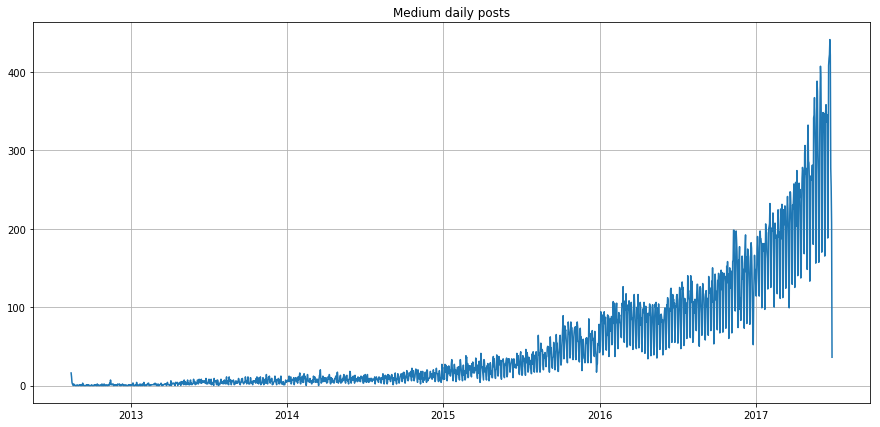

In [28]:
plt.figure(figsize=(15, 7))
plt.plot(daily_df.posts)
plt.title('Medium daily posts')
plt.grid(True)
plt.show()

In [29]:
weekly_df = daily_df.resample('W').apply(sum)

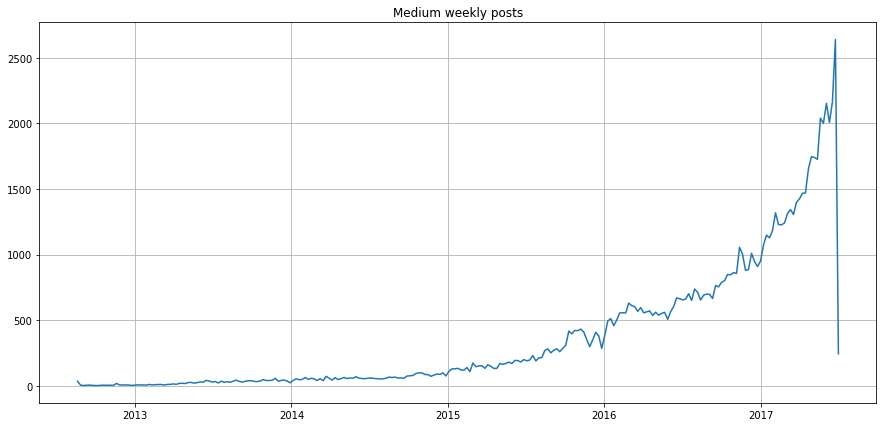

In [31]:
plt.figure(figsize=(15, 7))
plt.plot(weekly_df.posts)
plt.title('Medium weekly posts')
plt.grid(True)

In [33]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [34]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
1775,2017-06-25,253
1776,2017-06-26,207
1777,2017-06-27,36


In [35]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
1745,2017-05-26,269
1746,2017-05-27,157
1747,2017-05-28,172


In [36]:
m = Prophet()
m.fit(train_df);

In [37]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1775,2017-06-25
1776,2017-06-26
1777,2017-06-27


In [38]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1775,2017-06-25,241.450434,204.521226,249.307512,241.305497,241.588014,-14.183033,-14.183033,-14.183033,-16.674844,-16.674844,-16.674844,2.491811,2.491811,2.491811,0.0,0.0,0.0,227.267401
1776,2017-06-26,241.883454,227.920308,275.082014,241.716135,242.027673,10.100099,10.100099,10.100099,7.587396,7.587396,7.587396,2.512703,2.512703,2.512703,0.0,0.0,0.0,251.983553
1777,2017-06-27,242.316475,232.381719,277.340204,242.126840,242.475589,11.869900,11.869900,11.869900,9.356236,9.356236,9.356236,2.513663,2.513663,2.513663,0.0,0.0,0.0,254.186374


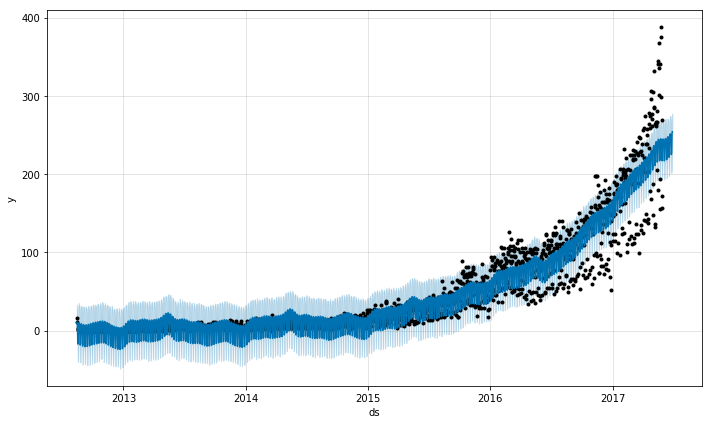

In [39]:
m.plot(forecast);

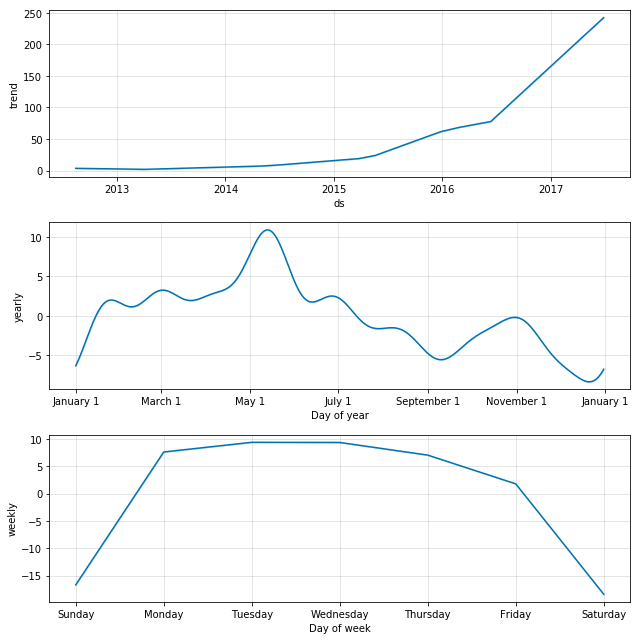

In [40]:
m.plot_components(forecast);

In [41]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [42]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-25,227.267401,204.521226,249.307512,253
2017-06-26,251.983553,227.920308,275.082014,207
2017-06-27,254.186374,232.381719,277.340204,36


In [43]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [44]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 46.892135441384625
MAE 97.53186105651838


In [55]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [56]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='blue'))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='blue'),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'New posts on Medium')

### Really bad prediction with the prophhet with the medium dataset ###